**Table of contents**<a id='toc0_'></a>    
- [Part 1: Investigating the completeness of the table.](#toc1_1_)    
    - [Finding the structure of the dataset](#toc1_1_1_)    
    - [Checking for Missing Data](#toc1_1_2_)    
    - [Dealing with Missing Data](#toc1_1_3_)    
      - [Missing Magnitude](#toc1_1_3_1_)    
        - [Error Fixing](#toc1_1_3_1_1_)    
      - [Plotting](#toc1_1_3_2_)    
        - [Analysis Of Graphs](#toc1_1_3_2_1_)    
      - [Missing Mass](#toc1_1_3_3_)    
        - [Separating Moons into 2 Groups](#toc1_1_3_3_1_)    
        - [Plotting the Graph](#toc1_1_3_3_2_)    
        - [Finding the Name of the Selected Moon](#toc1_1_3_3_3_)    
        - [Eccentricity](#toc1_1_3_3_4_)    
      - [Missing Data Conclusion](#toc1_1_3_4_)    
  - [Part 2: Investigating correlations between fields](#toc1_2_)    
    - [Aims of the Section](#toc1_2_1_)    
      - [Initial Plotting](#toc1_2_1_1_)    
      - [Analysis](#toc1_2_1_2_)    
    - [Initial Plots](#toc1_2_2_)    
    - [Correlation Matrix](#toc1_2_3_)    
    - [Analysis of previous plots](#toc1_2_4_)    
      - [Period, Distance and Inclination](#toc1_2_4_1_)    
      - [Magnitude, Radius and Distance](#toc1_2_4_2_)    
        - [Distance](#toc1_2_4_2_1_)    
      - [Eccentricity vs Distance](#toc1_2_4_3_)    
    - [Correlations Conclusion](#toc1_2_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [154]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.patches as patch

Accessing the database "jupiter.db" using pandas and creating a variable to contain the details of the database and another to act as the database.

In [155]:
database_service = "sqlite"
database = "jupiter.db"
connectable =  f"{database_service}:///{database}" ## Creating a variable to connect to the database

db_contents = pd.read_sql("SELECT * FROM sqlite_master", connectable) ## Creating a variable to contain the details of the database

moons = pd.read_sql("SELECT * FROM moons", connectable) ## Creating a variable to contain the details of the moons table

## <a id='toc1_1_'></a>[Part 1: Investigating the completeness of the table.](#toc0_)

### <a id='toc1_1_1_'></a>[Finding the structure of the dataset](#toc0_)

In [156]:
## Finding how many moons are documented in the moons table
row_count = moons.shape[0]
print(f'There are {row_count} rows in the moons table.')
if row_count < 95:
    missing = 95 - row_count
    print(f'(There are thought to be 95 moons of Jupiter, therefore {missing} are missing from this database.)')
print("\n")

## Finding the names and data types of each variable in the moons table
data_types = moons.dtypes
print("The names and data types of each variable in the moons table are as follows:")
print(data_types.to_string())

There are 56 rows in the moons table.
(There are thought to be 95 moons of Jupiter, therefore 39 are missing from this database.)


The names and data types of each variable in the moons table are as follows:
moon                object
period_days        float64
distance_km        float64
radius_km          float64
mag                float64
mass_kg            float64
group               object
ecc                float64
inclination_deg    float64


As the code above shows, there are 39 of the known moons of Jupiter missing from this database. I would assume that this is due to the missing moons being in the groups of small, irregular moons that are difficult to measure values for and would not be impactful in this study. 

### <a id='toc1_1_2_'></a>[Checking for Missing Data](#toc0_)

Next I will check for missing values throughout the data frame so that they can be cleaned appropriately, either by finding reliable data from a trusted source, i.e. NASA.gov, or by omitting them from tests that would be impacted by a lack of a value.

In [157]:
missing_data = moons.isnull().sum() ##Using the .isnull() functionj from pandas to create a table displaying which fields are missing values and hopw many each field is missing.
missing_df = pd.DataFrame(missing_data, columns=['Missing Values'])
missing_df

,Missing Values
moon,0
period_days,0
distance_km,0
radius_km,0
mag,3
mass_kg,50
group,0
ecc,0
inclination_deg,0


### <a id='toc1_1_3_'></a>[Dealing with Missing Data](#toc0_)

#### <a id='toc1_1_3_1_'></a>[Missing Magnitude](#toc0_)

From the 'missing' table above, it can be noted that 3 values of magnitude are not included in the jupiter.db file. To determine the potential reasoning for this, I will find which moons these are and assign them to a data frame with all of their values for the other fields. I suspect it is due to their proximity to Jupiter as that would make it difficult to produce a clear magnitude value for them, so, for comparison I will also show one moon from each group plotted onto a scatter graph alongside the moons with missing values. Also, I will check if there are any moons in the same group as them that do have values to understand why these specifically do not.

In [158]:
missing_mag = moons.loc[moons["mag"].isnull()] ## Variable that contains the rows of the moons table where the magnitude value is missing
print(missing_mag[["moon", "group"]].to_string(index=False))
    

    moon group
Adrastea Inner
   Metis Inner
   Thebe Inner


From the above result, it is clear that there is a link between a moon being in the inner group and not having a recorded magnitude. This is unless the error in the data set is random and not systematic, as that would suggest there is no reasoning behind the value being omitted. Now I check whether any other moons are in the "Inner" group

In [159]:
moons_filtered = moons[moons["group"] == "Inner"] ## Creating a variable that contains only the rows of the moons table where the group is "Inner"
moons_filtered = moons_filtered[~moons_filtered['moon'].isin(missing_mag['moon'])] 
print("The moons in the 'Inner' group with a recorded magnitude value are: ")
print(moons_filtered["moon"].to_string(index=False))

The moons in the 'Inner' group with a recorded magnitude value are: 
Amalthea


There is only one moon with a recorded magnitude in the inner group, so I will also plot this onto a scatter graph with the other moons to understand what could be different between them.

In [160]:
groups = moons["group"].unique() ## Creates an array of the unique group names in the moons table
groups = groups[groups != "Inner"] ## RRemoving Inner from groups as I will use all of the inner moons in the plot
print("The unique group names in the moons table are as follows:")
for i in groups:
    print(i)

The unique group names in the moons table are as follows:
Carme
Ananke
Pasiphae
Galilean
other
Himalia
Hamilia


After checking the group names, I noticed that the 'Himalia' and 'Hamilia' groups are very similar in name and suspected this could be a potential spelling error. After researching on NASA., I found the group named 'Himalia' but there was no mention of a 'Hamilia' group anywhere. To confirm, I found will find which moons are connected to it in the data frame.

In [161]:
hamilia = moons.loc[moons["group"] == "Hamilia"] ## Variable that contains the rows of the moons table where the group is "Hamilia"
print(hamilia[["moon", "group"]].to_string(index=False))

    moon   group
Lysithea Hamilia


##### <a id='toc1_1_3_1_1_'></a>[Error Fixing](#toc0_)

As shown above, the only result is Lysithea, so I checked the NASA website for details on it and found that it is a part of the Himalia group, **not** the 'Hamilia' group. [1]

To correct this I will alter the group field for Lysithea, remove 'Hamilia' from the list of groups and continue with the plotting.

In [162]:
moons.loc[moons['moon'] == 'Lysithea', 'group'] = 'Himalia' ## Correcting the group name for Lysithea from 'Hamilia' to 'Himalia'
groups = groups[groups != "Hamilia"] ## Removing 'Hamilia' from the groups 

#### <a id='toc1_1_3_2_'></a>[Plotting](#toc0_)

In [163]:
   
moons_list = ['Amalthea', 'Adrastea', 'Metis', 'Thebe'] ## Array to store randomly selected names of moons from each group
label = ["Amalthea",""] ## Array used to label selected moons on the plot
for i in groups:
    size = moons.loc[moons["group"] == i, "moon"].count() ## Counts the number of moons in each group
    num = random.randint(0, size-1)
    moons_list.append(moons.loc[moons["group"] == i, "moon"].iloc[num]) ## Adds a randomly selected moon from each group to the moons_list array
    if i == "Galilean":
        label[1] = moons_list[-1] ## Adding the randomly selected Galilean moon to the label array for labelling on the plot
label

['Amalthea', 'Callisto']

I chose to randomly generate which moon from each group is used as to keep the integrity of the comparison and make sure there was no bias as to which moons where used.

The scatter graph will be a graph of log(radius_km) against log(distance_km) using the moons in the 'moons_list' list as the data points.
First I will create a data frame for the moons involved with the required variables.

In [164]:
graph = moons[moons["moon"].isin(moons_list)] ## Variable containing the rows of values for the necessary moons.
graph = graph[['moon', 'radius_km', 'distance_km']].reset_index(drop=True) ## Filtering the graph variable to only contain the necessary fields

## Applying logarithmic scale to the radius_km and distance_km fields
graph['radius_km'] = np.log2(graph['radius_km']) 
graph['distance_km'] = np.log10(graph['distance_km']) 

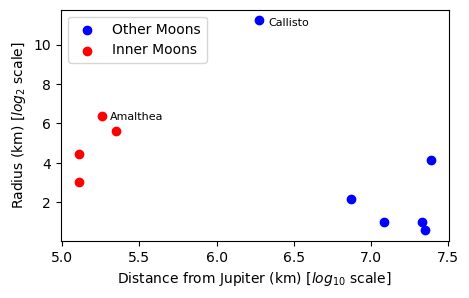

In [165]:
plt.figure(figsize=(5,3)  )

highlight = ['Amalthea', 'Adrastea', 'Metis', 'Thebe'] ## Inner moons to highlight on the scatter plot

## Separating the data frame to highlight the inner moons
inner = graph[graph['moon'].isin(highlight)] 
not_inner = graph[~graph['moon'].isin(highlight)] 

for i, row in graph.iterrows():
    if row['moon'] in label:
        plt.text(row['distance_km'] * 1.01, row['radius_km'] * 0.99, row['moon'], 
                 fontsize=8, ha='left', va='center')

## Plotting the inner moons as a red point and the other moons as blue points
plt.scatter(not_inner['distance_km'], not_inner['radius_km'], label='Other Moons', color='blue')
plt.scatter(inner['distance_km'], inner['radius_km'], label='Inner Moons', color='red') 

plt.xlabel(r'Distance from Jupiter (km) [$log_{10}$ scale]')
plt.ylabel(r'Radius (km) [$log_{2}$ scale]')
plt.legend()
plt.show()

![rad-dist-1.png](rad-dist-1.png)   ![rad-dist-2.png](rad-dist-2.png)  ![rad-dist-3.png](rad-dist-3.png)

##### <a id='toc1_1_3_2_1_'></a>[Analysis Of Graphs](#toc0_)

Above are a set of three scatter graphs using a different set of randomly selected moons. From these graphs, it is clear that the inner moons are much closer to Jupiter than the other moons, apart from the Galilean moons. This suggests that, even though the outer moons have a similar or even smaller radii than the inner moons, they are far away enough from Jupiter for a clear magnitude reading to be observed. 

However, Amalthea is also an inner moon and is even closer to Jupiter than one of the other inner moons that does not have a magnitude value. It does however have a larger radius than any of the other moons in its group. Using this, I would suggest that the reason for the missing values of magnitude is due to a combination of size and proximity to Jupiter. Due to the Inner and Galilean groups of moons being close to Jupiter, the size of the moon appears to impact its observability more than its distance, as the magnitude of the moons is likely blocked by Jupiter's own magnitude affecting the observable light.  
This means that if the moon is not large enough, there is not a clear way of determining its magnitude, hence Amalthea and the Galilean moons are recordable due to them being large enough to stand out from Jupiter whereas Adrastea, Metis and Thebe do not have the required radius to stand out from the much larger mass of Jupiter.

From this comparison, I will attempt to clean the data by simply omitting these affected moons from any tests where magnitude is relevant, instead of attempting to find data from trusted sources.

#### <a id='toc1_1_3_3_'></a>[Missing Mass](#toc0_)

Now that the 3 missing magnitude values have been dealt with, there is a significant amount of mass values that are not recorded in the jupiter.db file.

To get an idea on what could be the cause of this, first I will compare the mass values that are recorded with the respective radius of the moons they represent.
I believe that by plotting a scatter graph of radius on the y-axis and distance on the x-axis, then colour coordinating the moons to show which have recorded masses and which don't, will give a clear visual of any correlation between mass being observable and radius/distance.

##### <a id='toc1_1_3_3_1_'></a>[Separating Moons into 2 Groups](#toc0_)

To start, I will use the 'moons' data frame to create two subsets of data, one for moons that have a mass recorded, and one for those that don't.

These subsets will contain the 'moon', 'distance', 'radius' and 'mass' fields as these will be useful in the analysis. Both will also contain the 'ecc' field as this will complete my analysis of the missing values at the end of this section.

(I will also include the 'group' field in the set without mass as I will use this in my analysis further on)

*Note: These cells will be runnable without the Missing Magnitude Cells*

In [166]:
## Altering the distance and radius values to be logarithmic for clearer visuals
temp = moons.copy()

temp["radius_km"] = np.log2(temp["radius_km"])
temp["distance_km"] = np.log10(temp["distance_km"])


with_mass = temp.loc[temp["mass_kg"].notnull(), ["moon", "distance_km", "radius_km", "mass_kg", "ecc"]] 
without_mass = temp.loc[temp["mass_kg"].isnull(), ["moon", "distance_km", "radius_km", "mass_kg", "group", "ecc"]] 

mass_moons = with_mass["moon"].tolist()

##### <a id='toc1_1_3_3_2_'></a>[Plotting the Graph](#toc0_)

Using the data frames created above, I will plot the scatter graph.

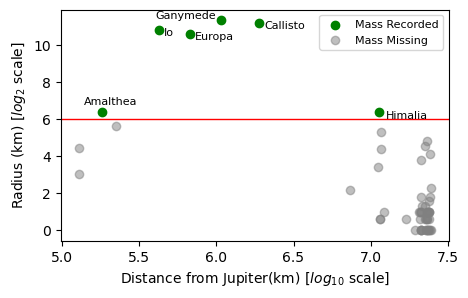

In [167]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(with_mass['distance_km'], with_mass['radius_km'], label='Mass Recorded', color='green')
ax.scatter(without_mass['distance_km'], without_mass['radius_km'], label='Mass Missing', color='grey', alpha = 0.5)

for i in range(6):
    if with_mass["moon"].iloc[i] == "Amalthea":
        ax.text(with_mass['distance_km'].iloc[i] * 1.01, with_mass['radius_km'].iloc[i] * 1.05, mass_moons[i], fontsize=8, ha='center', va='bottom')
    elif with_mass["moon"].iloc[i] == "Ganymede":
        ax.text(with_mass['distance_km'].iloc[i] * 0.995, with_mass['radius_km'].iloc[i] * 1, mass_moons[i], fontsize=8, ha='right', va='bottom')
    else:
        ax.text(with_mass['distance_km'].iloc[i] * 1.006, with_mass['radius_km'].iloc[i] * 1.01, mass_moons[i], fontsize=8, ha='left', va='top')

ax.set_xlabel(r'Distance from Jupiter(km) [$log_{10}$ scale]')
ax.set_ylabel(r'Radius (km) [$log_{2}$ scale]')

ax.legend(fontsize = '8');
ax.axhline(y = 6, color='red', linestyle = '-', linewidth = 1) ## Line to show separation - explained further down
plt.show()

![mass-missing.png](mass-missing.png)

This figure is the one produced by the code in the cell above, before I added the red line. I have labelled all the moons which have recorded masses, and they are also indicated by green markers instead of grey, as the legend indicates.

This graph suggests that the radius of the moon is a large factor in the ability to measure mass, as is indicated by a seemingly clear cut-off point in radial values where mass is not recorded.
To demonstrate this clearer I added the horizontal line as seen in the figure above.

From this result, I can infer that the reason for a lack of measurements is likely due to the unrecorded moons having too small of a radius to be accurately measured for mass.

This is due to mass being measured by inspecting the gravitational forces from the moon which is dependent on the mass being large enough to have a noticeable field.

This is done for moons of Jupiter most accurately by observing the orbit of a spacecraft around the moon for a period of time, then using Newton's Laws of Gravitation and Newton's 2ndLaw to find the equation:
$$M = \frac{ar^2}{G}$$
where M is the mass of the planet, r is the radius of the planet, a is the acceleration of the spacecraft and G is the gravitational constant.

This means that more very accurate readings, a lot of effort is taken to have a spacefract sent to the moon and placed into an orbit, suggesting that for smaller moons this may not have been performed yet, due to it not being seen as necessary once the larger moons have been recorded.

To double check that masses for the smaller moons have not been found, I will find out which moon is the one just below himalia on the graph and researching to try and find an accurate mass value.

(Even though the moon just below Amalthea has a larger radius than the one I have chosen, from the previous section of missing magnitude, I found that this moon, along with the other Inner group moons are not as documented as some of the outer ones, due to there proximity to Jupiter overshadowing their size, so I will avoid looking for them.)

##### <a id='toc1_1_3_3_3_'></a>[Finding the Name of the Selected Moon](#toc0_)

To find the name of the moon, I will perform a linear scan as the dataset being searched through (~50 values) is not large enough to warrant any kind of sorting algorithm to increase efficiency.

I will first filter out the 'Inner' group of moons as I have already decided I do not want to use them in this step, then I will set an upper bound on the radius that is less than the radius value of the line added above because all the moons I am looking at fall below this value.

In [168]:
smaller_moons = without_mass.loc[without_mass["group"] != "Inner"]
largest = smaller_moons["radius_km"].idxmax()
largest = smaller_moons.loc[largest, "moon"]
print(f'The largest moon that does not have a recorded mass and is not in the Inner group is {largest}.')

The largest moon that does not have a recorded mass and is not in the Inner group is Elara.


From this knowledge that Elara is the moon I was interested in I looked into papers published which mentioned anything about its mass. However, there were no papers built around finding the mass of Elara, only how it has been used to find the masses of other moons such as Himalia, as is done in this paper [2].

Due to the fact that there are no accurate readings of Elara's mass even though it is the largest of the moons I was searching through, I determined that the best course of action would be to not attempt to fill in the missing values from the jupter.db and omit the involved data points from future tasks should mass be a factor in them.

##### <a id='toc1_1_3_3_4_'></a>[Eccentricity](#toc0_)

From looking at the data I also noticed that there could be a link with moons that have no mass observed having a higher eccentricity than those that do.

To compare these I will create a simple graph of eccentricity on the x-axis and distance from Jupiter on the y-axis. 

(I don't believe the distance axis is necessary however it allows me to analyse how distance and eccentricity could be linked in a later section.)

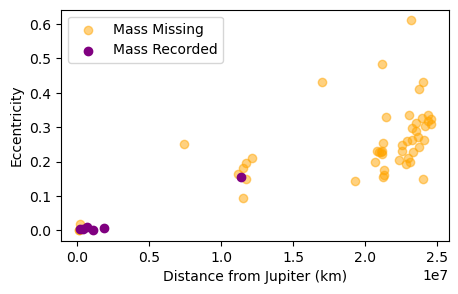

In [169]:
## Using the raw values from moons, not the logarithmic scale
with_mass = moons.loc[moons["mass_kg"].notnull(), ["moon", "distance_km", "ecc"]]
without_mass = moons.loc[moons["mass_kg"].isnull(), ["moon", "distance_km", "ecc"]] 

plt.figure(figsize = (5,3))
plt.scatter(without_mass["distance_km"], without_mass["ecc"], color = "Orange", alpha = 0.5, label = "Mass Missing")
plt.scatter(with_mass["distance_km"], with_mass["ecc"], color = "Purple", label = "Mass Recorded")

plt.xlabel(r'Distance from Jupiter (km)')
plt.ylabel('Eccentricity')

plt.legend()
plt.show()


This graph shows how the majority of moons without a mass value tend to have a larger eccentricity value than the ones that do. Obviously, this is not the case for all of them, as the 3 moons of the inner group without values are shown to be close to Jupiter with a low eccentricity, however, as shown before, it is difficult to measure readings for that set of moons. 
Surprisingly, Himalia actually has a larger eccentricity than some moons that are at a similar distance to Jupiter that do not have recorded masses however I believe it is large enough to still be found. 

From this figure, I would infer that eccentricity is a factor in the ability to find a moons mass, due to a moon irregular orbit impacting the ability to model its movements and gravitational effects being less consistent.

(I will discuss the relationship between distance and eccentricity in a further section.)

#### <a id='toc1_1_3_4_'></a>[Missing Data Conclusion](#toc0_)

From the two sections above on missing data found in the jupiter.db file, I believe that this set of data has been suitably investigated and cleaned without impacting the integrity of the raw data.

It will be suitable to use this cleaned data in further tasks without fear of it being incomplete or inaccurate in any way.

## <a id='toc1_2_'></a>[Part 2: Investigating correlations between fields](#toc0_)

### <a id='toc1_2_1_'></a>[Aims of the Section](#toc0_)

#### <a id='toc1_2_1_1_'></a>[Initial Plotting](#toc0_)

First, I will create plots of all numeric fields from the database using seaborn's 'pairplot' function. This will allow me to easily see any clear correlations between fields, and analyse any connections closely. 

I will exclude the mass_kg field from the numeric fields I use as it contains a very limited set of data, so I do not believe it to be sufficient to prove any connection to other fields.

After these pairplots, I will create a matrix of the correlation coefficients for each field's comparison to clearly display which fields would be interesting to look into.

#### <a id='toc1_2_1_2_'></a>[Analysis](#toc0_)

From the first plots, I will then lay out which connections I will analyse further, based on the information I have gained at that point.

I will take a correlation coefficient value of |r| > 0.75 as a highly significant correlation, and therefore this will decide which fields I look into.
However, if a value is close to this boundary, I will decide based on which fields are involved and the distribution plots for those fields.

### <a id='toc1_2_2_'></a>[Initial Plots](#toc0_)

In [170]:
import seaborn as sns

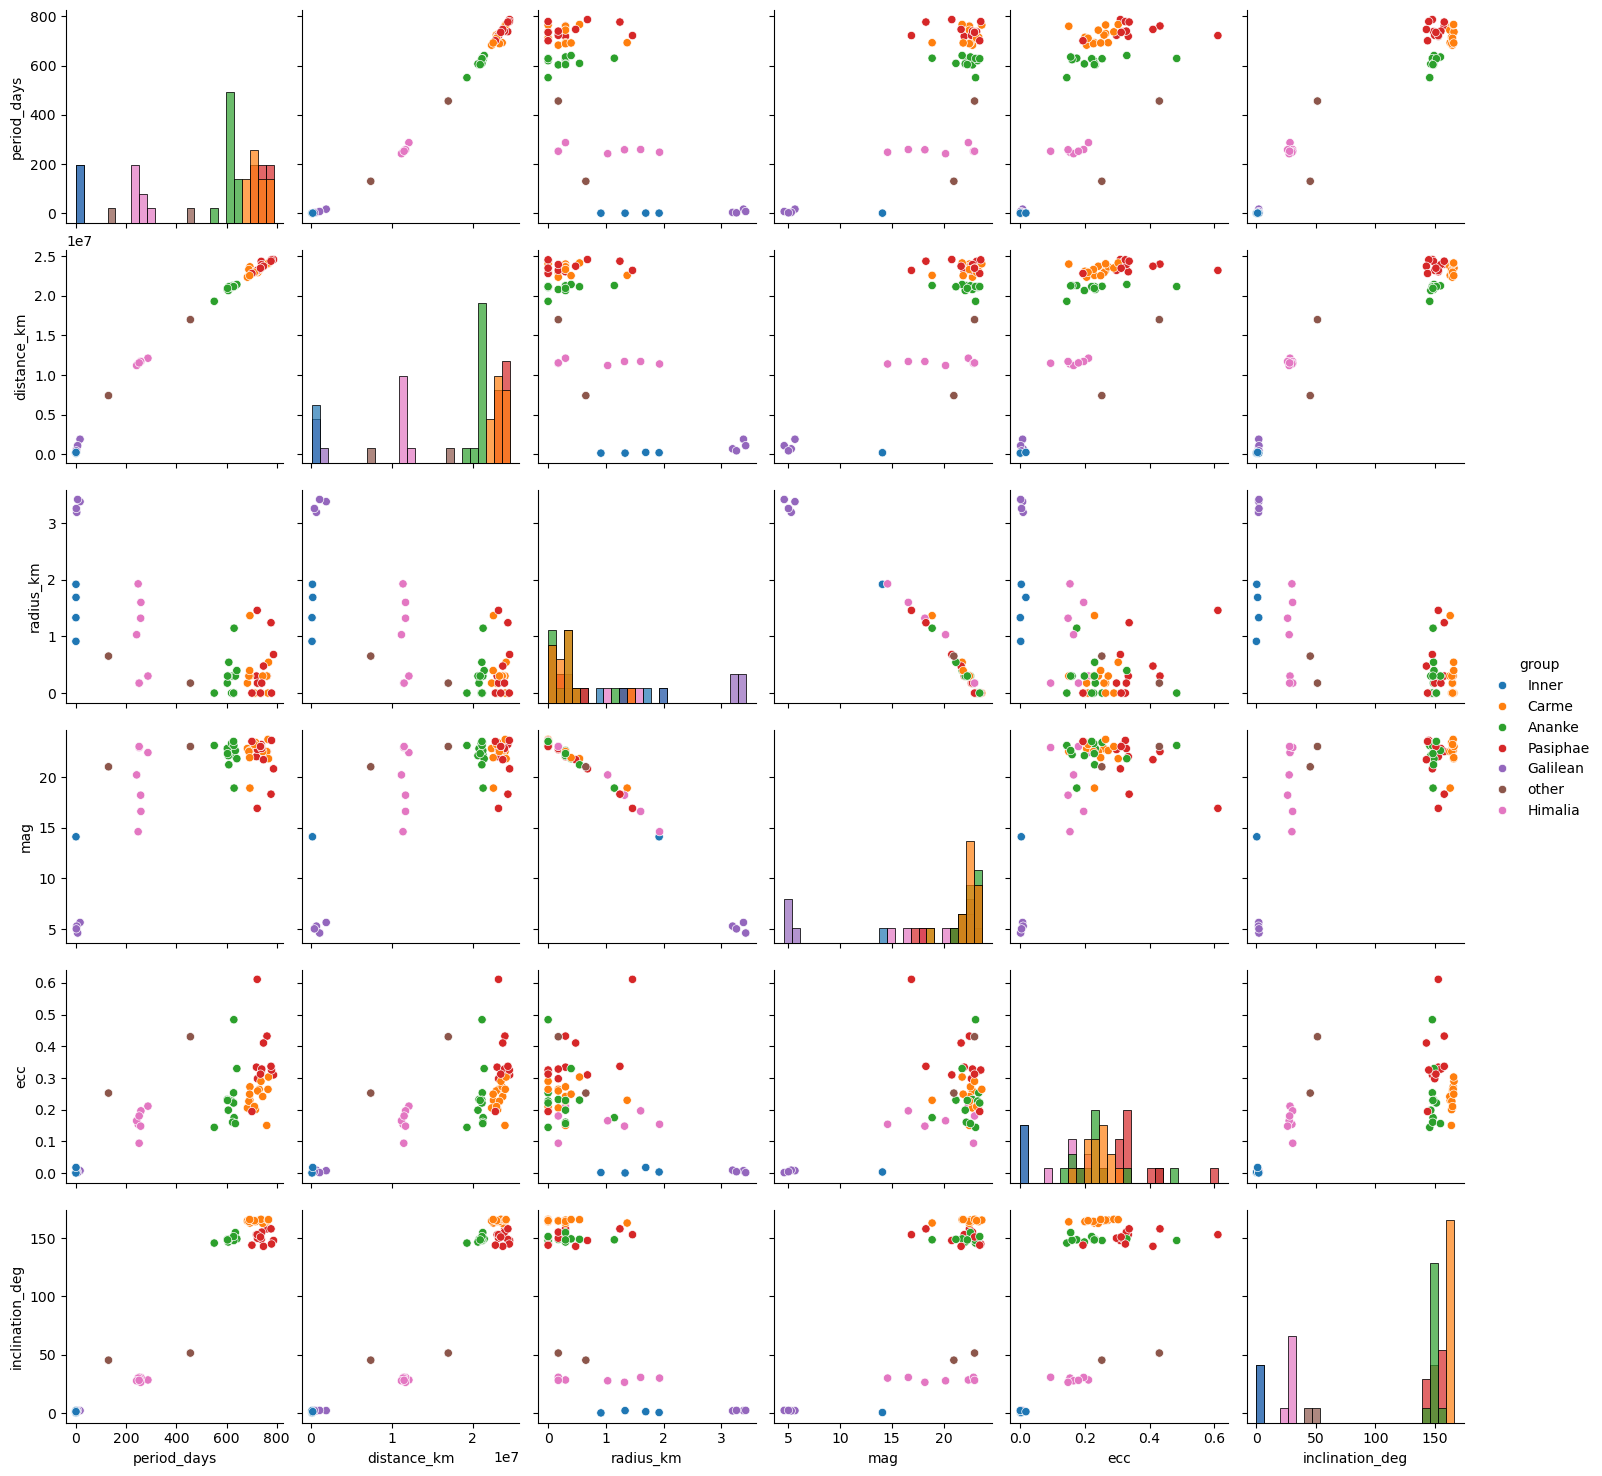

In [171]:
numeric_cols = [
    "period_days",
    "distance_km",
    "radius_km",
    "mag",
    "ecc",
    "inclination_deg"
]

log_cols = ["radius_km"]
moons_log = moons.copy()
moons_log[log_cols] = moons_log[log_cols].apply(np.log10) ## Radius is the only variable that benefits from logarithmic scaling here

sns.pairplot(
    moons_log[numeric_cols + ["group"]],
    hue = "group",
    diag_kind = "hist",
    diag_kws = {"common_norm": False, "bins": 25, "alpha": 0.7}, ## Histograms do not spike as much as kde plots along the diagonal
    corner = False    
)

plt.show()



### <a id='toc1_2_3_'></a>[Correlation Matrix](#toc0_)

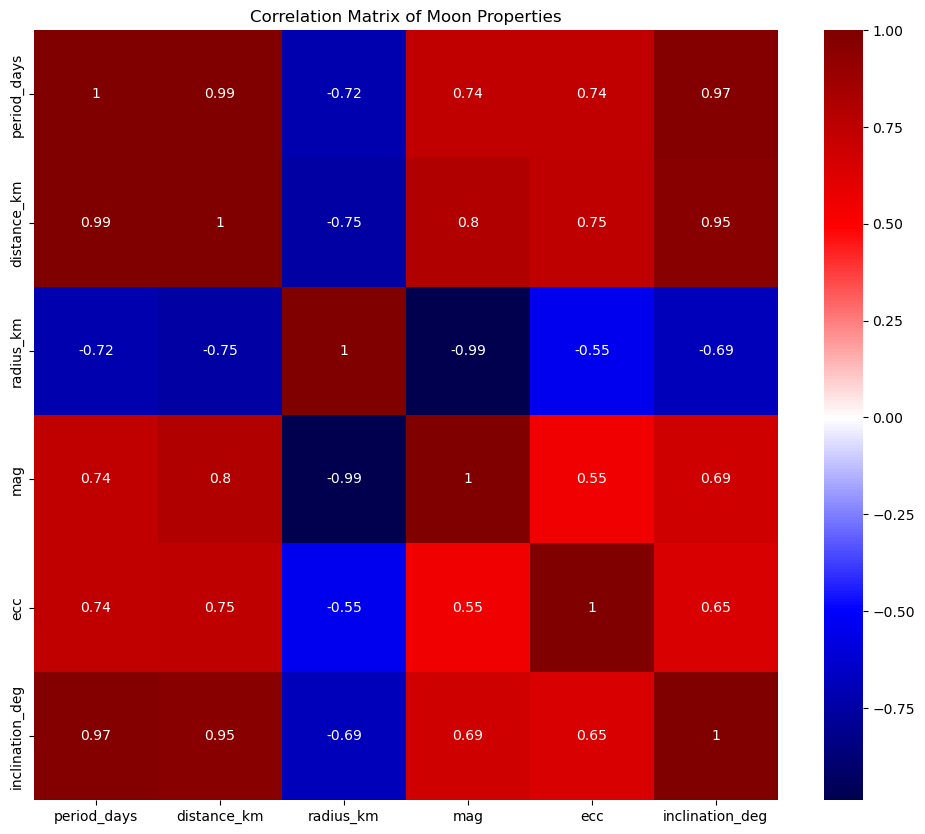

In [172]:
corr = moons_log.corr(numeric_only = True)

plt.figure(figsize=(12,10))
sns.heatmap(corr.loc[numeric_cols, numeric_cols], annot = True, cmap = "seismic", center = 0)
plt.title("Correlation Matrix of Moon Properties")

plt.show()

### <a id='toc1_2_4_'></a>[Analysis of previous plots](#toc0_)

From the plots above, there are some clear connections between multiple fields. The most significant are the connections between period and distance as well as the correlation between radius and magnitude, with them both having an r-value extremely close to 1.

Also to note, the degree of inclination also appears to have strong correlations with both distance and period, so to clearly show the relationship between all 3, I will plot them all together.

The main correlations I will investigate will be:

**1. Period vs Distance**

**2. Degree of Inclination vs Distance**

**3. Magnitude vs Radius**

**4. Magnitude vs Distance**

It appears that any field with a strong correlation with distance also has a similar strength of correlation with period, due to period($T$) and distance($a$) being linked very closely to Kepler's Third Law stating that 
$$T^2 = \frac{4\pi^{2}}{GM} a^3$$
Due to this, I will hopefully see a linear relationship between period cubed and distance squared when they are plotted, which should create a line of fit with a gradient that is expected to equal $\frac{4\pi^{2}}{GM}$ due to 
$$T^2 \propto a^3$$

From observing the top 2 rows of graphs above, it is clear that distance and period, when compared with another field, produce very similar trends, therefore it seems unnecessary to analyse both period and distance for fields that have a strong correlation with both. Because of this, I will only check the relationship between a field and **distance** when the correlation coefficient is significant enough to suggest a connection.  

  
   
On top of the correlations above, I will also look into the connection between distance and radius, as this shows to still have a significant r value, even though it is below the boundary value set earlier.

Eccentricity and distance also have a significant correlation value, so I will look into the connection between the two as well.

#### <a id='toc1_2_4_1_'></a>[Period, Distance and Inclination](#toc0_)

To plot these fields clearly, I will plot a 2D scatter graph of 

x-axis = distance_km $^3$  
y-axis = period_days $^2$  

and then another scatter plot of  

x-axis = distance_km  
y-axis = inclination_deg    

This will allow me to look for the relationship between distance and period that Kepler described as well as seeing how inclination relates to distance.  
I will also colour code the moons by their groups to determine if there is any pattern between groups.

In [173]:
## Created an easily reusable function for plotting scatter plots with seaborn

def scat_plot(data, x, y, alpha = 0.7, hue = "group", **kwargs):
    sns.scatterplot(data = data, x = x, y = y, alpha = alpha, hue = hue, **kwargs)
    
## Doing the same for regression line creation

def reg_line(data, x, y, scatter = False, color = "black", line_kws = {"linestyle":"--"}, **kwargs):
    sns.regplot(data = data, x = x, y = y, scatter = scatter, color = color, line_kws = line_kws, **kwargs)

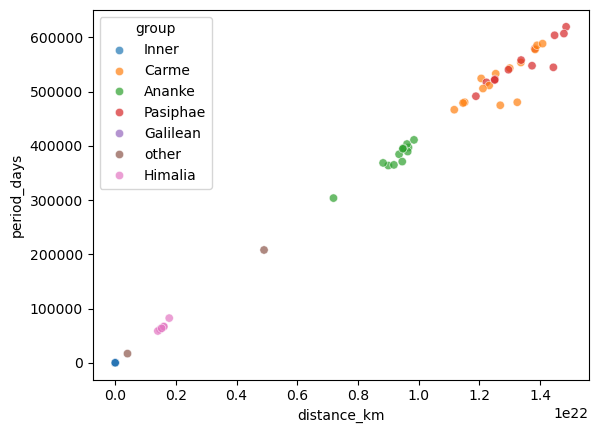

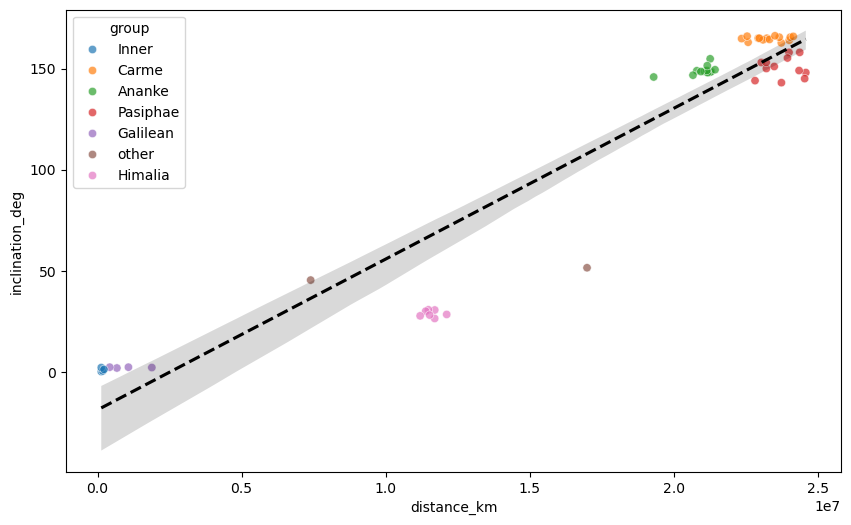

In [174]:
moons_kepler = moons.copy()
moons_kepler["distance_km"] = moons_kepler["distance_km"] ** 3
moons_kepler["period_days"] = moons_kepler["period_days"] ** 2


plt.figure()

scat_plot(
    data = moons_kepler,
    x = "distance_km",
    y = "period_days",
)

plt.show()


plt.figure(figsize = (10,6))

scat_plot(
    data = moons,
    x = "distance_km",
    y = "inclination_deg",
)

reg_line(
    data = moons,
    x = "distance_km",
    y = "inclination_deg"
)


plt.show()



The first of these three graphs clearly shows the linear relationship between period cubed and distance squared, just as stated by Kepler.  
*I will look further into this in Task 2*

The following graph of *inclination_deg* against *distance_km* shows a positive correlation, as suggest from the correlation matrix above. This could be due to the outer moons of Jupiter consisting of many objects that were captured by Jupiter's orbit, as opposed to being formed in the circumplanetary disk, which surrounded Jupiter when it was young, as the larger, closer moons were [3]. Due to them being captured, there is a much greater chance that they entered the orbit at more varied angles, and as more objects were captured, groups were formed due to the moons having similar distances - as shown above - which caused the moons at larger inclinations to remain at similar angles to Jupiter with the other moons in the group.

As shown by the regression line on the plot, most of the points are clustered close to the line, showing how there is a correlation between the two fields.

#### <a id='toc1_2_4_2_'></a>[Magnitude, Radius and Distance](#toc0_)

In the matrix of graphs above, the radius value has a logarithmic scale of $log_{10}$ applied to it, so first I will plot the raw radius values along the x-axis and the magnitude values along the y-axis, to check if there is a correlation for the raw values.

I also have to filter out the three inner moons that do not have magnitude values, as these will prevent a correlation from being calculated using the function 'np.corrcoef'.

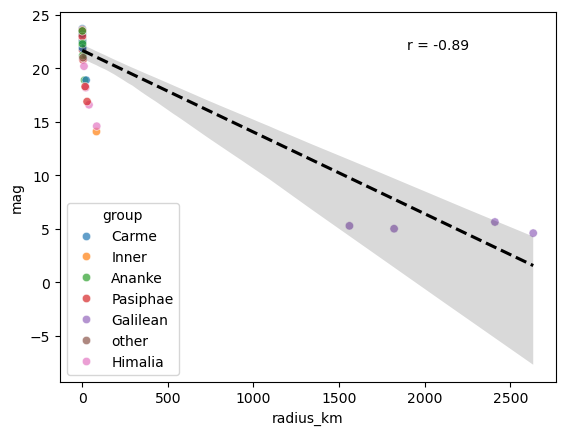

In [175]:
moons_filtered = moons[moons["mag"].notnull()]

plt.figure()
scat_plot(
    data = moons_filtered,
    x = "radius_km",
    y = "mag"
)

r = np.corrcoef(moons_filtered["radius_km"], moons_filtered["mag"])[0,1]
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')
reg_line(
    data = moons_filtered,
    x = "radius_km",
    y = "mag"
)
plt.show()

This r-value is about 10% lower than the value found when the $log_{10}$ values of radius are used, so I will plot these next and investigate the connection between radius(log) and magnitude.

(I can use the moons_log data frame for this from earlier)

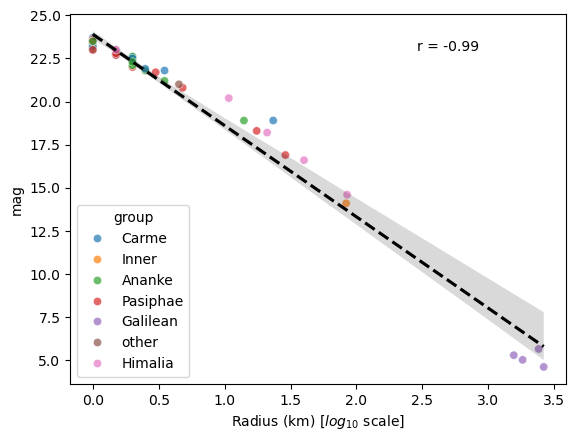

In [176]:
moons_log = moons_log[moons_log["mag"].notnull()]

plt.figure()
scat_plot(
    data = moons_log,
    x = "radius_km",
    y = "mag"
)

r = np.corrcoef(moons_log["radius_km"], moons_log["mag"])[0,1]
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')
reg_line(
    data = moons_log,
    x = "radius_km",
    y = "mag"
)

plt.xlabel(r'Radius (km) [$log_{10}$ scale]')
plt.show()

The regression line on the above plot clearly displays how the correlation for these values is much higher than for the raw values.

This is likely due to the equation for magnitude being 
$$ m = -2.5 log_{10} (F) + C$$
where F is the flux of the moon

Flux and radius are linked as the area of a moons that reflects light from the sun towards Earth to be measured is in the shape of a circle, therefore is an area of $\pi r^2$ and $F \propto r^2$ 
(where r is radius)

Using this connection, by replacing F with $r^2$ in the m equation and rearranging, the equation becomes
$$m = -5 log_{10}(r) +C$$

Using the graph above, I can find the gradient using 'np.polyfit' and determine whether these points fit this trend.

In [177]:
gradient, _ = np.polyfit(moons_log["radius_km"], moons_log["mag"], 1)

standard_dev = stats.linregress(moons_log["radius_km"], moons_log["mag"]).stderr

print(f'The gradient of the line of best fit is {gradient:.2f}.')
print(f'The gradient is {standard_dev:.2f} standard deviations away from the expected value')

The gradient of the line of best fit is -5.29.
The gradient is 0.11 standard deviations away from the expected value


The value of -5.29 is very close to the expected value of -5 for this trend, 0.11 standard deviations out, therefore these values fit the expected pattern for the connection between magnitude and radius.

##### <a id='toc1_2_4_2_1_'></a>[Distance](#toc0_)

I believe that the connection between distance and magnitude is due to the connection between radius and distance.  

Radius and distance are linked, in Jupiter's case, as the moons that were formed early tend to be created from the circumplanetary disk around the planet, creating moons with larger, more regular shapes than the outer ones, which were captured in the orbit and may be much smaller.  
There are also much fewer moons in close proximity to Jupiter than moons further out, as shown by multiple prior graphs. This means that these moons have clearer orbits, with much fewer opportunities to collide with objects and diminish in size, as opposed to the outer moons which are in much more populated orbits, as shown by the inclination vs distance graph, therefore many may have been chipped away and shrunk over many years, hence creating the difference in sizes and the high correlation between the two fields.

Due to this connection, the correlation between distance and magnitude is closely linked to the magnitude - radius connection, which explains why the correlation values for both are high.

#### <a id='toc1_2_4_3_'></a>[Eccentricity vs Distance](#toc0_)

Eccentricity and distance are likely linked due to the further out moons having been captured by the orbit, not naturally formed. This increases the chance of the capture path being at a higher eccentricity to the moons closer to Jupiter, as well as the moons being affected by greater external forces from objects such as the Sun and other outer moons, creating a none circular orbit about Jupiter.

To show the difference in eccentricities, I will create a diagram of some orbits around Jupiter, ignoring the inclination of each orbit, using the 'moons_list' variable from earlier as the selected moons.

Note. $$e = \sqrt{1 - \frac{b^2}{a^2}}$$
is the equation for eccentricity of an ellipse, where 'a' is the semi-major axis (distance-_km) and 'b' is the semi-minor axis

/Applications/anaconda3/lib/python3.13/site-packages/matplotlib/transforms.py:2054: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 0] *= sx
/Applications/anaconda3/lib/python3.13/site-packages/matplotlib/transforms.py:2055: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 1] *= sx
/Applications/anaconda3/lib/python3.13/site-packages/matplotlib/transforms.py:2056: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 2] *= sx
/Applications/anaconda3/lib/python3.13/site-packages/matplotlib/transforms.py:2057: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[1, 0] *=

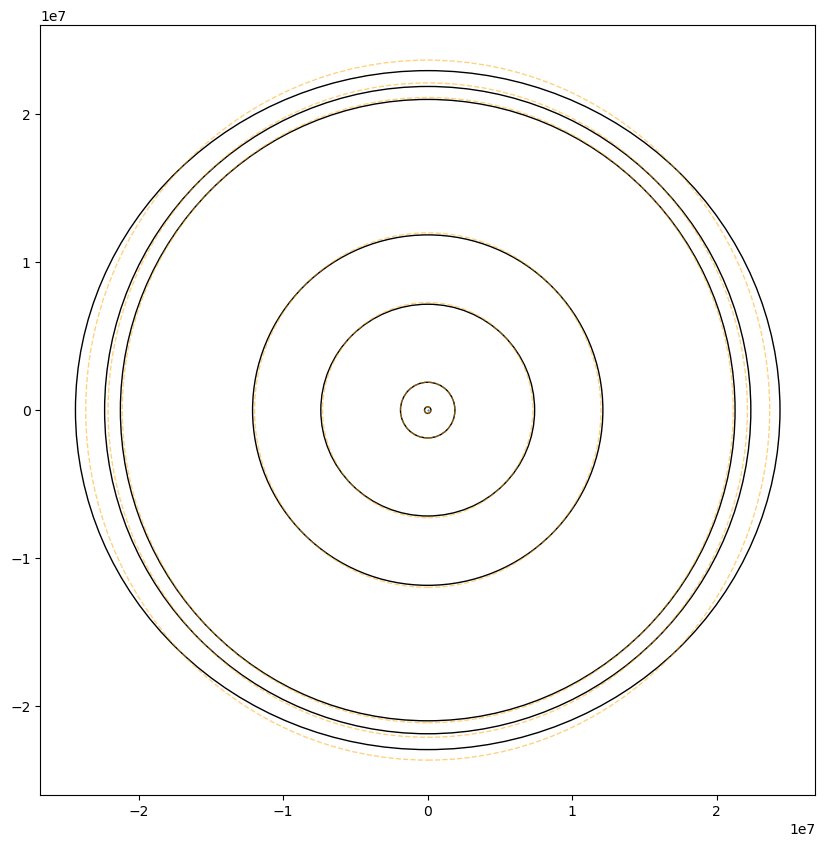

In [178]:
moon_ellipse = moons_list[3:]   ## Removing 3 of the inner moons to clear up the visual

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(0, 0, '.', markersize = 1) 
for moon in moon_ellipse:
    data = moons.loc[moons["moon"] == moon]
    a = data["distance_km"]
    e = data["ecc"]
    b = a * np.sqrt(1 - e**2)
    
    ellipse = patch.Ellipse(
        (0,0),
        width = 2 * a,
        height = 2 * b,
        fill = False,
        label = moon
    )
    ax.add_patch(ellipse)
    
    ## Adding a circular orbit alongside each ellpise to show the deviation from a circular path.
    circle = patch.Circle(
        (0,0),
        radius = (a + b)/2,
        fill = False,
        linestyle = '--',
        color = 'orange',
        alpha = 0.5
    )
    ax.add_patch(circle)

plt.show()
    
    

This figure clearly shows how eccentricity tends to increase with distance, as well a showing how there are larger clusters of moons further out, which would potentially increase eccentricity due to multiple gravitational forces acting upon each object, while the force from Jupiter is not as strong as for the closer moons.

### <a id='toc1_2_5_'></a>[Correlations Conclusion](#toc0_)

From this section, it is clear that there are many links and correlations between fields in the jupiter.db database. Some of these connections can be easily explained by an equation of some kind and can therefore be checked graphically, whereas others are more obscure links, where factors outside the database, such as where the moon came from, seem to provide a link between the fields that can be explained.

Throughout the analysis, the moons on the graphs have been colour coded into their separate groups, to make it easy to check for any extra connections between group and other fields. The only fields that seemed to show groups being clearly separated on the graphs were distance, period and inclination, which is to be expected as these fields are likely the main factors in determining which group a moon belongs to due to them denoting the structure and position of the moons orbital path, therefore moons with a similar path are going to be grouped together.

# <a id='toc4_'></a>[**References:**](#toc0_)

[1]: Link - [https://science.nasa.gov/jupiter/jupiter-moons/lysithea/](https://science.nasa.gov/jupiter/jupiter-moons/lysithea/)  

[2]: The mass of Himalia from the perturbations on other satellites, N. V. Emelyanov, A&A 438 (3) L33-L36 (2005)
     DOI: 10.1051/0004-6361:200500143  

[3]: Serman, M. (2019), "On the origin of the moons of Jupiter", *Delf University of Technology*, Section 1. pages 6-8    

[4]: Link - https://ssd.jpl.nasa.gov/planets/phys_par.html